In [ ]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)
your_private_repo = "Disciplinas-FEEC/EA979-2023S1" #@param {"type": "string"}

addr = f"git@github.com:{your_private_repo}.git"
!git clone $addr

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
data_dir = "EA979-2023S1/exercicios/Ex06_imagens//Brain_Tumor_Dataset"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Deep Learning para detecção de tumores no cérebro

In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Carregar dados

Este código carrega imagens 2D de cérebros saudáveis e cérebros contendo tumores usando um dataloader.

In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=24, shuffle=True, num_workers=6) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda', index=0)

In [ ]:
print(dataset_sizes)

{'train': 143, 'val': 62, 'test': 48}


# Visualizando algumas imagens (um batch)

Batch of training data


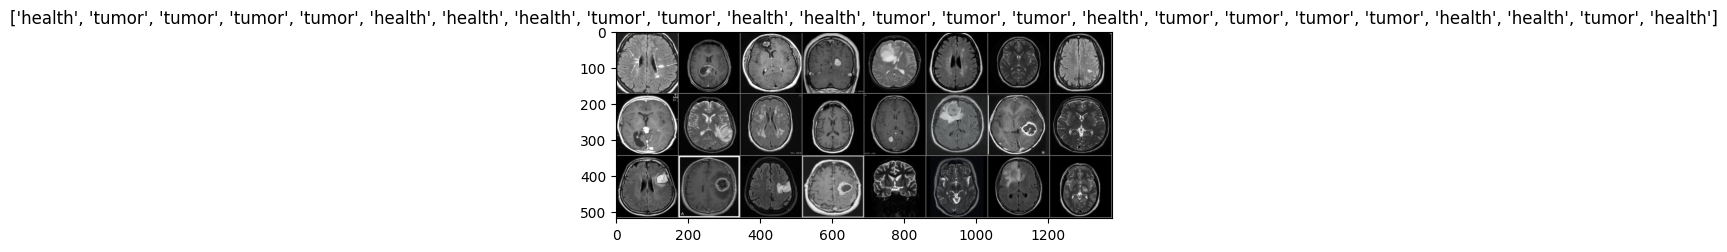

Batch of validation data


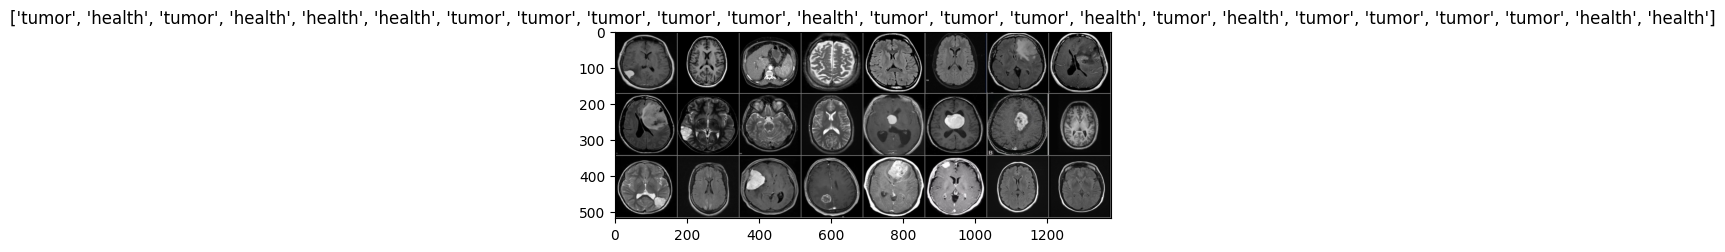

Batch of test data


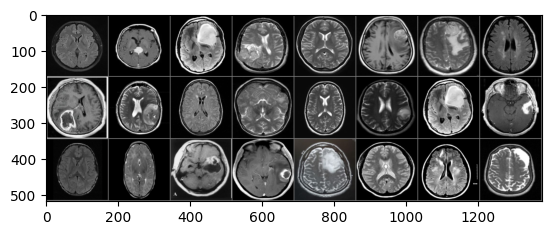

('gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test23.jpeg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test33.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test25.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test35.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test16.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test47.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test46.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test18.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test29.JPG', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test28.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex06/Brain_Tumor_Dataset/test/test/test8.jpg', 'gdrive/MyDrive/G_EA979A_2023S1/EA979A_Ex0

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Treinando o modelo

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'train':
                LOSS_train.append(epoch_loss)
                ACC_train.append(epoch_acc)
            if phase == 'val':
                LOSS_val.append(epoch_loss)
                ACC_val.append(epoch_acc)
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


# Testando o modelo

In [ ]:
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig = plt.figure(figsize=(50, 50))
                plt.tight_layout() 
                plt.subplot(num_images, 1, images_so_far)
                plt.axis('off')
                print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Experimento

**Sem transfer learning:** Inicialização randômica e todos os pesos são retreinados.

In [ ]:
model_ft_randstart = models.resnet18(pretrained=False)
num_ftrs = model_ft_randstart.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_randstart.fc = nn.Linear(num_ftrs, 2)

model_ft_randstart = model_ft_randstart.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_randstart = optim.SGD(model_ft_randstart.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_randstart, step_size=200, gamma=0.5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
model_ft_randstart

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model_ft_randstart, (3, 170, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_randstart = train_model(model_ft_randstart, criterion, optimizer_ft_randstart, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.6832 Acc: 0.5455
val Loss: 0.6507 Acc: 0.6613

Epoch 1/199
----------
train Loss: 0.6554 Acc: 0.6294
val Loss: 0.6413 Acc: 0.6613

Epoch 2/199
----------
train Loss: 0.6064 Acc: 0.6434
val Loss: 0.6331 Acc: 0.6613

Epoch 3/199
----------
train Loss: 0.6043 Acc: 0.6853
val Loss: 0.6203 Acc: 0.6613

Epoch 4/199
----------
train Loss: 0.5568 Acc: 0.6573
val Loss: 0.6090 Acc: 0.6613

Epoch 5/199
----------
train Loss: 0.5493 Acc: 0.8042
val Loss: 0.5923 Acc: 0.6613

Epoch 6/199
----------
train Loss: 0.5244 Acc: 0.7343
val Loss: 0.5770 Acc: 0.6613

Epoch 7/199
----------
train Loss: 0.5104 Acc: 0.7413
val Loss: 0.5470 Acc: 0.6935

Epoch 8/199
----------
train Loss: 0.4687 Acc: 0.8462
val Loss: 0.5420 Acc: 0.7419

Epoch 9/199
----------
train Loss: 0.4426 Acc: 0.8252
val Loss: 0.5001 Acc: 0.7258

Epoch 10/199
----------
train Loss: 0.4291 Acc: 0.8182
val Loss: 0.5058 Acc: 0.7419

Epoch 11/199
----------
train Loss: 0.4045 Acc: 0.8531
val Loss: 0.4788 Acc

path: test2.jpg / predicted: tumor


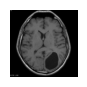

path: test32.JPG / predicted: tumor


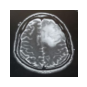

path: test10.JPG / predicted: health


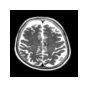

path: test45.JPG / predicted: tumor


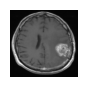

path: test19.png / predicted: health


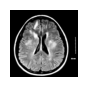

path: test48.JPG / predicted: tumor


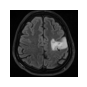

path: test11.jpg / predicted: health


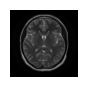

path: test42.jpg / predicted: tumor


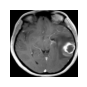

path: test5.jpg / predicted: tumor


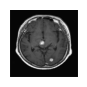

path: test13.jpg / predicted: health


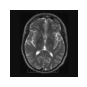

path: test34.JPG / predicted: tumor


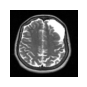

path: test27.jpg / predicted: tumor


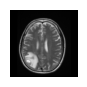

path: test47.JPG / predicted: tumor


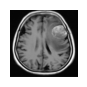

path: test24.jpg / predicted: tumor


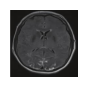

path: test12.jpg / predicted: health


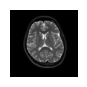

path: test44.JPG / predicted: tumor


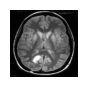

path: test6.JPG / predicted: tumor


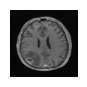

path: test21.jpg / predicted: tumor


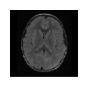

path: test29.JPG / predicted: tumor


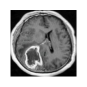

path: test3.jpg / predicted: tumor


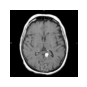

path: test36.JPG / predicted: tumor


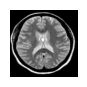

path: test4.jpg / predicted: tumor


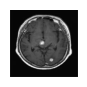

path: test25.jpg / predicted: tumor


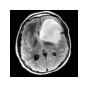

path: test30.JPG / predicted: tumor


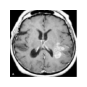

path: test15.jpeg / predicted: health


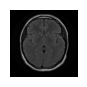

path: test8.jpg / predicted: health


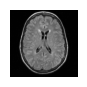

path: test26.jpg / predicted: tumor


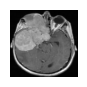

path: test23.jpeg / predicted: health


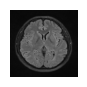

path: test46.JPG / predicted: tumor


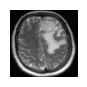

path: test1.jpg / predicted: tumor


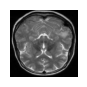

path: test22.jpg / predicted: health


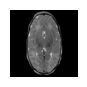

path: test37.JPG / predicted: tumor


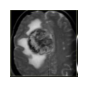

path: test9.JPG / predicted: health


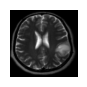

path: test43.JPG / predicted: tumor


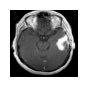

path: test14.jpg / predicted: health


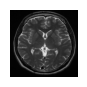

path: test20.jpg / predicted: health


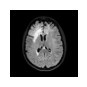

path: test16.jpg / predicted: tumor


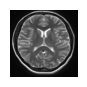

path: test41.jpg / predicted: tumor


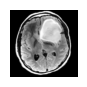

path: test40.JPG / predicted: tumor


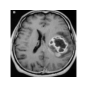

path: test35.JPG / predicted: tumor


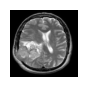

path: test31.JPG / predicted: tumor


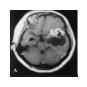

path: test28.jpg / predicted: health


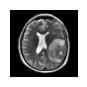

path: test7.JPG / predicted: tumor


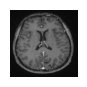

path: test17.jpeg / predicted: health


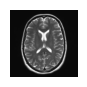

path: test33.JPG / predicted: health


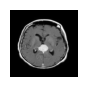

path: test39.JPG / predicted: tumor


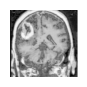

path: test18.jpg / predicted: health


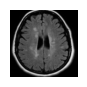

path: test38.JPG / predicted: tumor


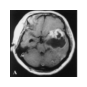

In [ ]:
test_model(model_ft_randstart)

# Visualizando as predições do modelo

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels, paths) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('path:{} predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

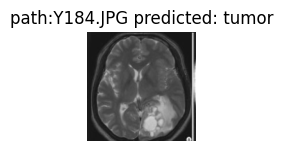

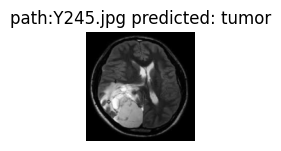

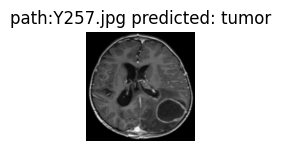

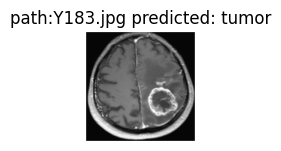

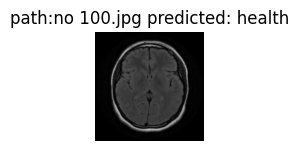

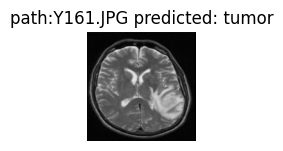

In [ ]:
visualize_model(model_ft_randstart)

### Experimento 2

**Finetuning:** Ao invés de inicialização randômica, utilize o mesmo modelo inicializando-o com uma rede pré-treinada.

In [ ]:
# static learning rate for 200 epochs

model_ft_pretrained = models.resnet18(pretrained=True)
num_ftrs = model_ft_pretrained.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft_pretrained.fc = nn.Linear(num_ftrs, 2)

model_ft_pretrained = model_ft_pretrained.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_pretrained.parameters(), lr=0.000005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=200, gamma=0.8)

summary(model_ft_pretrained, (3, 170, 170))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_ft_pretrained = train_model(model_ft_pretrained, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.9472 Acc: 0.4196
val Loss: 0.7991 Acc: 0.4194

Epoch 1/199
----------
train Loss: 0.9375 Acc: 0.4126
val Loss: 0.8977 Acc: 0.3548

Epoch 2/199
----------
train Loss: 0.9321 Acc: 0.4056
val Loss: 0.9835 Acc: 0.3548

Epoch 3/199
----------
train Loss: 0.8827 Acc: 0.4196
val Loss: 0.9993 Acc: 0.3387

Epoch 4/199
----------
train Loss: 0.8660 Acc: 0.4615
val Loss: 0.9740 Acc: 0.3548

Epoch 5/199
----------
train Loss: 0.8438 Acc: 0.4406
val Loss: 0.9518 Acc: 0.3710

Epoch 6/199
----------
train Loss: 0.8141 Acc: 0.4476
val Loss: 0.9186 Acc: 0.3871

Epoch 7/199
----------
train Loss: 0.7792 Acc: 0.4895
val Loss: 0.8898 Acc: 0.3871

Epoch 8/199
----------
train Loss: 0.7694 Acc: 0.4755
val Loss: 0.8657 Acc: 0.3871

Epoch 9/199
----------
train Loss: 0.7791 Acc: 0.4615
val Loss: 0.8371 Acc: 0.3548

Epoch 10/199
----------
train Loss: 0.7326 Acc: 0.5385
val Loss: 0.8011 Acc: 0.3871

Epoch 11/199
----------
train Loss: 0.7202 Acc: 0.5315
val Loss: 0.7712 Acc

### Experimento 3

Congele os pesos do modelo inicializado com uma rede pré-treinada, com exceção da última camada totalmente conextada. Esta última camada deve ser substituída com uma nova camada. Esta nova camada deve ser inicializada com pesos randômicos e somente esta camada deve ser treinada.


In [ ]:
model_conv_pretreined = torchvision.models.resnet18(pretrained=True)
for param in model_conv_pretreined.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_pretreined.fc.in_features
model_conv_pretreined.fc = nn.Linear(num_ftrs, 2)

model_conv_pretreined = model_conv_pretreined.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv_pretreined.fc.parameters(), lr=0.00008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=200, gamma=0.8)

summary(model_conv_pretreined, (3, 170, 170))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 85, 85]           9,408
       BatchNorm2d-2           [-1, 64, 85, 85]             128
              ReLU-3           [-1, 64, 85, 85]               0
         MaxPool2d-4           [-1, 64, 43, 43]               0
            Conv2d-5           [-1, 64, 43, 43]          36,864
       BatchNorm2d-6           [-1, 64, 43, 43]             128
              ReLU-7           [-1, 64, 43, 43]               0
            Conv2d-8           [-1, 64, 43, 43]          36,864
       BatchNorm2d-9           [-1, 64, 43, 43]             128
             ReLU-10           [-1, 64, 43, 43]               0
       BasicBlock-11           [-1, 64, 43, 43]               0
           Conv2d-12           [-1, 64, 43, 43]          36,864
      BatchNorm2d-13           [-1, 64, 43, 43]             128
             ReLU-14           [-1, 64,

In [ ]:
LOSS_train = []
LOSS_val = []
ACC_train = []
ACC_val = []

model_conv_pretreined = train_model(model_conv_pretreined, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------
train Loss: 0.6553 Acc: 0.6364
val Loss: 0.6209 Acc: 0.6290

Epoch 1/199
----------
train Loss: 0.6513 Acc: 0.6364
val Loss: 0.6439 Acc: 0.6452

Epoch 2/199
----------
train Loss: 0.6269 Acc: 0.6434
val Loss: 0.6886 Acc: 0.6452

Epoch 3/199
----------
train Loss: 0.6211 Acc: 0.6643
val Loss: 0.7205 Acc: 0.6613

Epoch 4/199
----------
train Loss: 0.6088 Acc: 0.6783
val Loss: 0.7112 Acc: 0.6290

Epoch 5/199
----------
train Loss: 0.6009 Acc: 0.6573
val Loss: 0.7030 Acc: 0.6290

Epoch 6/199
----------
train Loss: 0.5768 Acc: 0.6993
val Loss: 0.6946 Acc: 0.6452

Epoch 7/199
----------
train Loss: 0.5749 Acc: 0.6643
val Loss: 0.6830 Acc: 0.6452

Epoch 8/199
----------
train Loss: 0.5597 Acc: 0.7133
val Loss: 0.6679 Acc: 0.6613

Epoch 9/199
----------
train Loss: 0.5568 Acc: 0.7343
val Loss: 0.6514 Acc: 0.6452

Epoch 10/199
----------
train Loss: 0.5634 Acc: 0.7133
val Loss: 0.6369 Acc: 0.6935

Epoch 11/199
----------
train Loss: 0.5291 Acc: 0.7413
val Loss: 0.6291 Acc

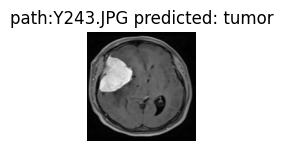

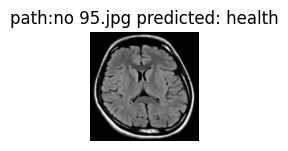

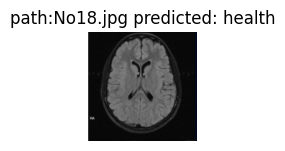

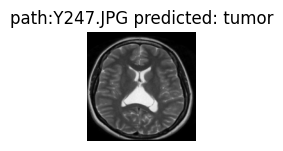

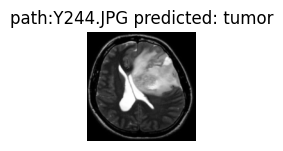

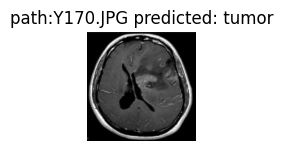

In [ ]:
visualize_model(model_conv_pretreined)

plt.ioff()
plt.show()

# Referências

- [Resnet-18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html)
- [Torchinfo](https://github.com/TylerYep/torchinfo).
- [Pytorch - Modelos pré-treinados](https://pytorch.org/vision/stable/models.html).
- [Neptune](https://neptune.ai)
- [Wandb](https://wandb.ai/). 